### Homework 3

In [1]:
import math
import requests
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use('seaborn')
pd.set_option('display.max_columns',None)

#### 1. Load data from csv

In [2]:
file_path = '../../../Lectures/Lecture 3/data/hw3.csv'

data = pd.read_csv(file_path)

In [3]:
data.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-12-02 14:00:00,22.4150,22.4913,22.0816,22.3516,31502.151631,NaN,UNI,ETH
1,2021-12-02 23:00:00,4.8043,4.8043,4.7426,4.7806,73686.230000,NaN,CRV,ETH
2,2021-12-10 15:00:00,182.4900,NaN,175.2100,175.8600,73736.747000,NaN,SOL,SOL
3,2021-12-10 18:00:00,3978.4300,3989.7400,3932.0000,3972.3400,18508.040102,NaN,ETH,ETH
4,2021-12-08 21:00:00,193.3240,194.2420,192.5640,193.1540,69426.909000,NaN,SOL,SOL


The dataset timestamp is **disordered**. Sort the dataset by `ts` first. 

In [4]:
data.sort_values(by='ts', inplace=True)
data.reset_index(drop=True, inplace=True)
data.shape

(2667, 9)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2667 entries, 0 to 2666
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ts         2667 non-null   object 
 1   open       2667 non-null   float64
 2   high       2163 non-null   float64
 3   low        2378 non-null   float64
 4   close      2531 non-null   float64
 5   volume     2667 non-null   float64
 6   volumeUSD  0 non-null      float64
 7   token      2667 non-null   object 
 8   chain      2667 non-null   object 
dtypes: float64(6), object(3)
memory usage: 187.6+ KB


#### 2. Data Cleaning

Basically, data cleaning includes following steps:
+ string formatting for categorical data 
+ drop duplicated data
+ detect outliers/abnormal data and replace them 
+ fill in the missing data

**1. string formatting**

There are a few rows where tokens are surrounded with tags.

In [6]:
data['token'].value_counts()

BTC                                   323
COMP                                  322
SOL                                   318
CRV                                   318
USDT                                  314
UNI                                   312
AAVE                                  312
ETH                                   298
<span name="tokenName">UNI</span>      30
<span name="tokenName">ETH</span>      28
<span name="tokenName">USDT</span>     19
<span name="tokenName">CRV</span>      17
<span name="tokenName">SOL</span>      16
<span name="tokenName">AAVE</span>     16
<span name="tokenName">BTC</span>      14
<span name="tokenName">COMP</span>     10
Name: token, dtype: int64

In [7]:
data.loc[data['token'].str.contains('span'), 'token'] = data.loc[
    data['token'].str.contains('span'), 'token'].str.extract('<span name="tokenName">(.*?)<\/span>').values

In [8]:
data['token'].value_counts()

UNI     342
BTC     337
CRV     335
SOL     334
USDT    333
COMP    332
AAVE    328
ETH     326
Name: token, dtype: int64

In [9]:
data['chain'].value_counts()

ETH     1663
BTC      337
SOL      334
USDT     333
Name: chain, dtype: int64

Categorical data is now well-formatted.

**2. drop duplicate data**

In [10]:
data.drop_duplicates(subset=['ts', 'token'], inplace=True)
data.reset_index(drop=True, inplace=True)
data.shape

(2360, 9)

In [11]:
data['token'].value_counts()

UNI     295
AAVE    295
ETH     295
SOL     295
USDT    295
COMP    295
BTC     295
CRV     295
Name: token, dtype: int64

Dropped `2667-2360=307` duplicated rows. Now there are `2360 / 8 = 295` rows for each token.

**3. replace abnormal data**

draw price plot for each token

In [12]:
def feature_plot(data, feature='close'):
    tokens_in_df = data.token.unique()
    fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 4 * math.ceil(tokens_in_df.size / 2)))

    idx = 0
    for label, df_token in data[['token', feature]].groupby('token'):
        df_token[feature].plot(ax=axes[idx // 2, idx % 2], label=label)
        axes[idx // 2, idx % 2].legend()

        idx += 1
    
    plt.suptitle(f'{feature} price plot for each token', y=1, fontsize=15)
    plt.tight_layout()

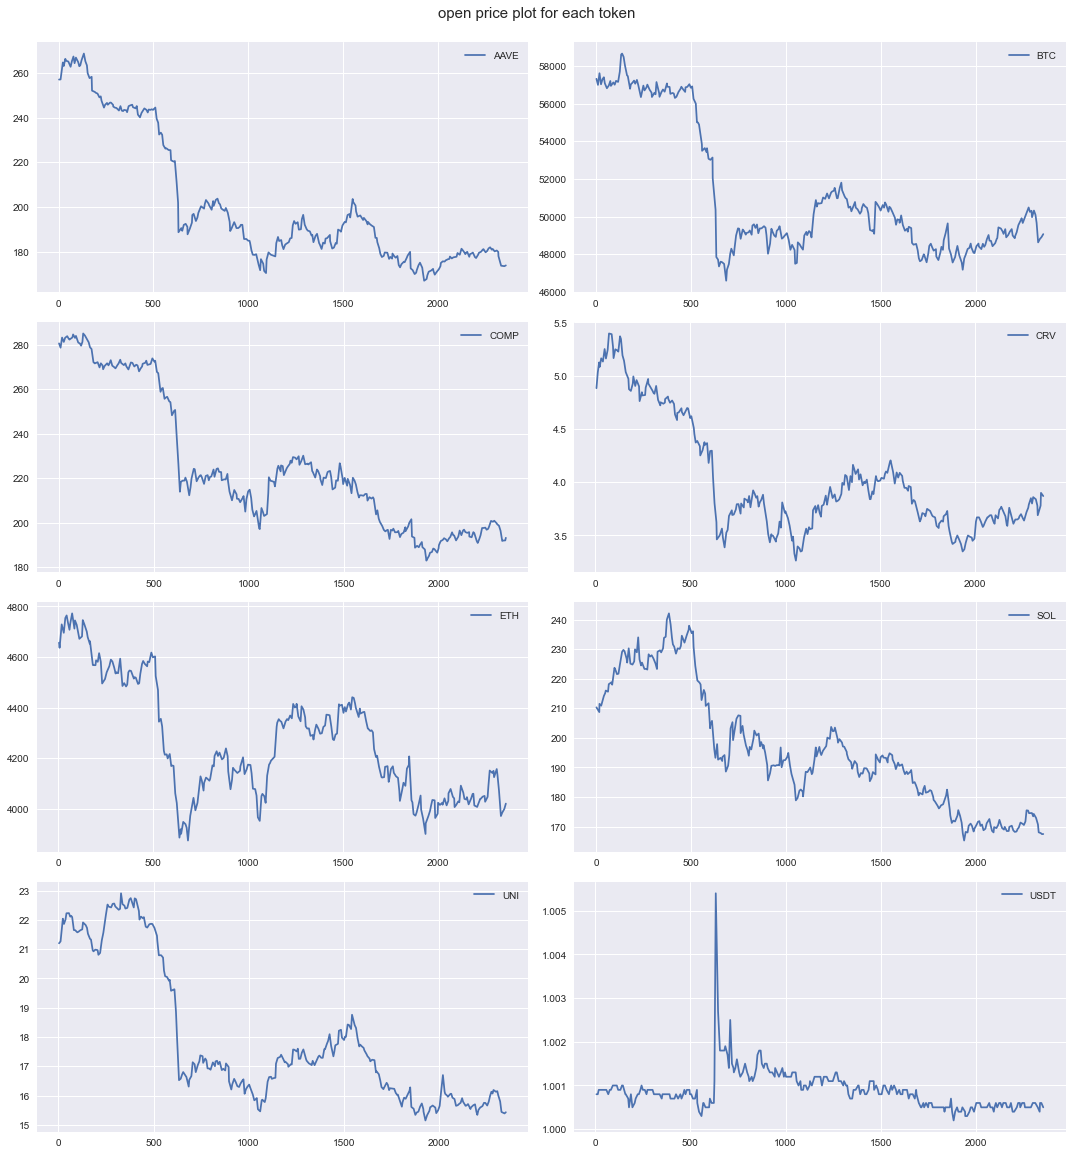

In [13]:
feature_plot(data, feature='open')

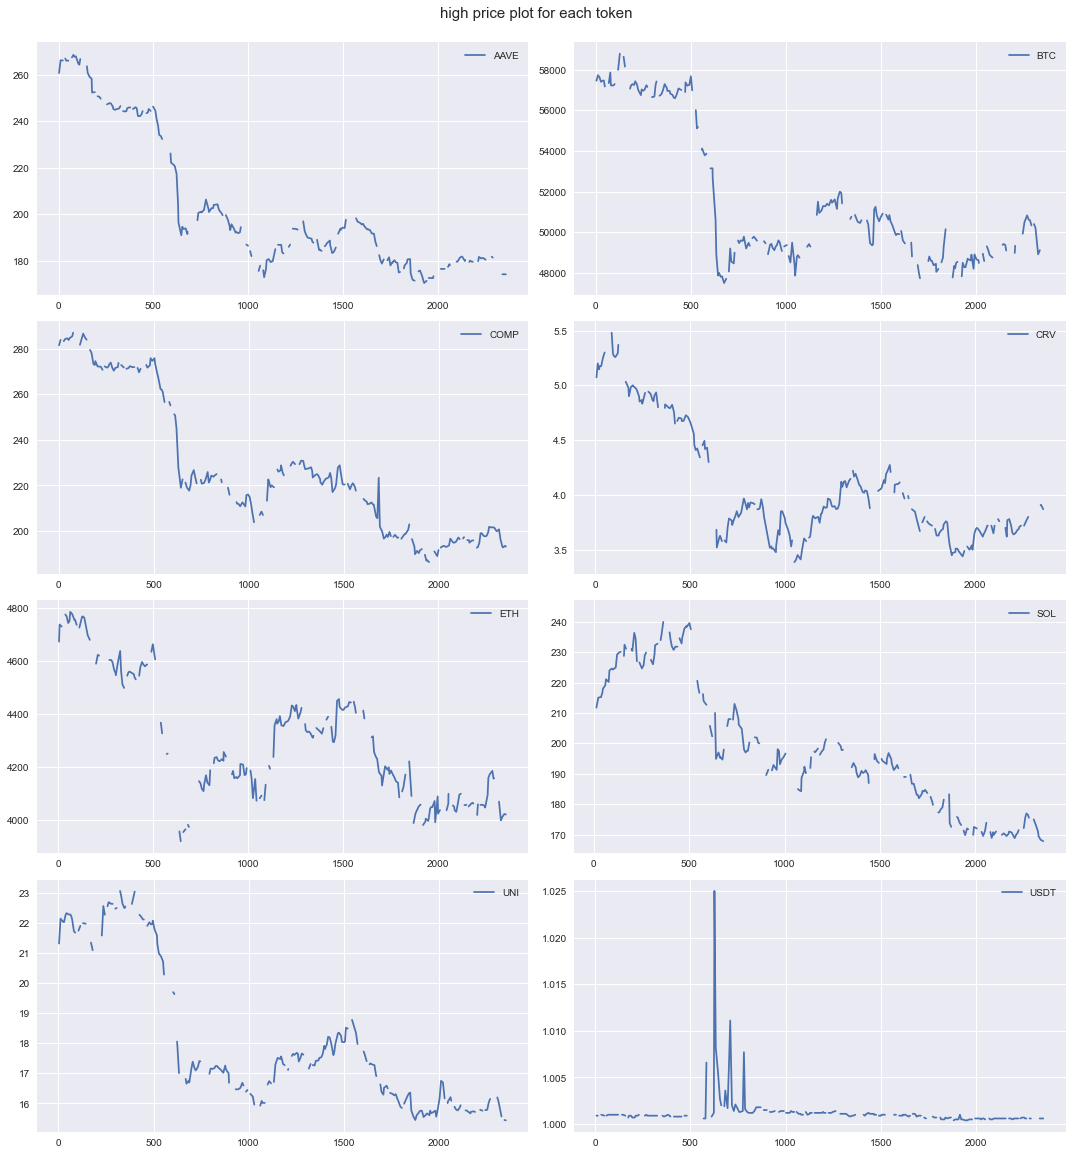

In [14]:
feature_plot(data, feature='high')

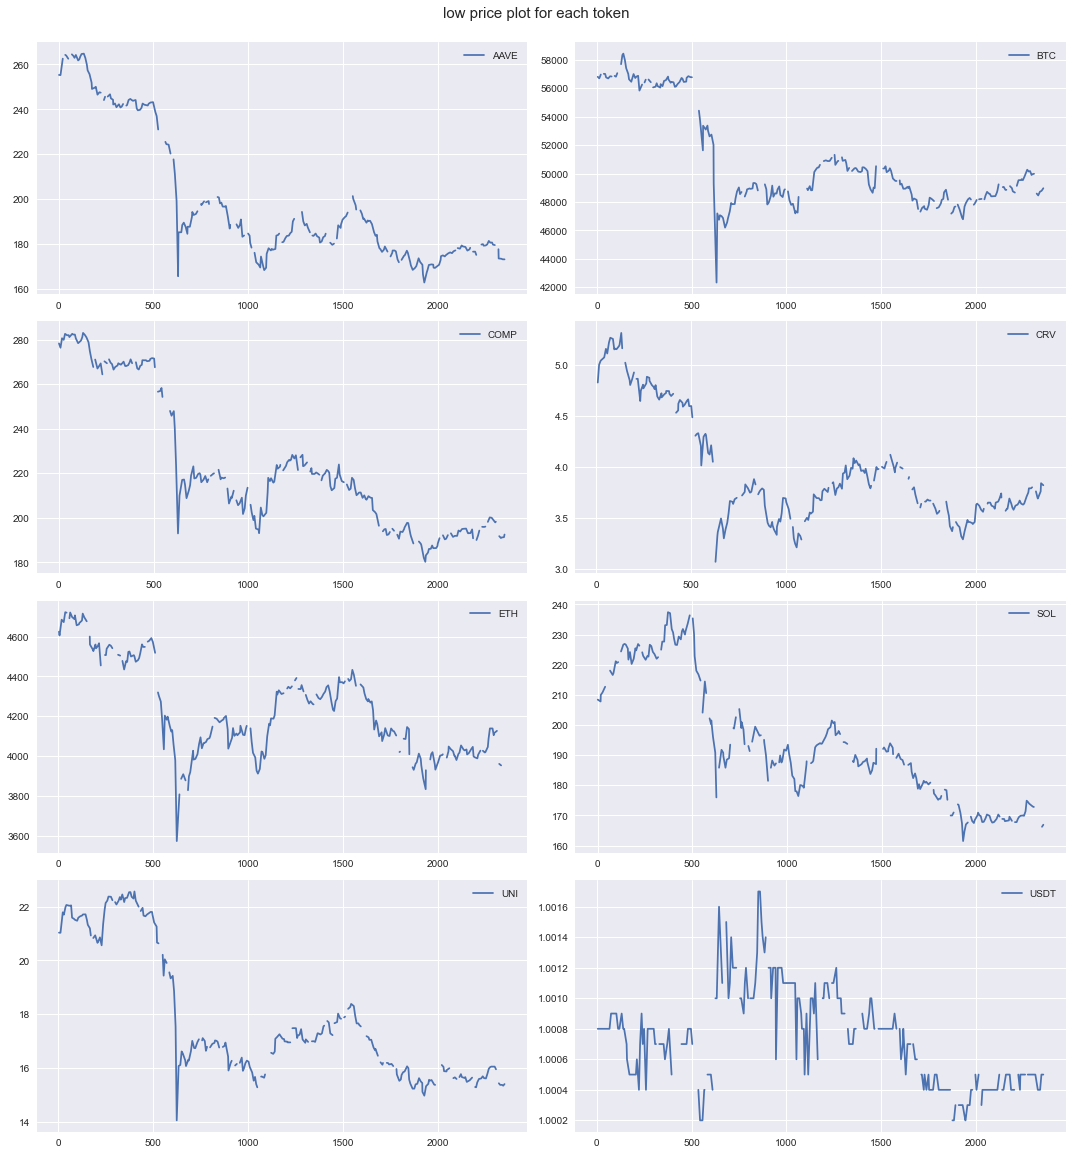

In [15]:
feature_plot(data, feature='low')

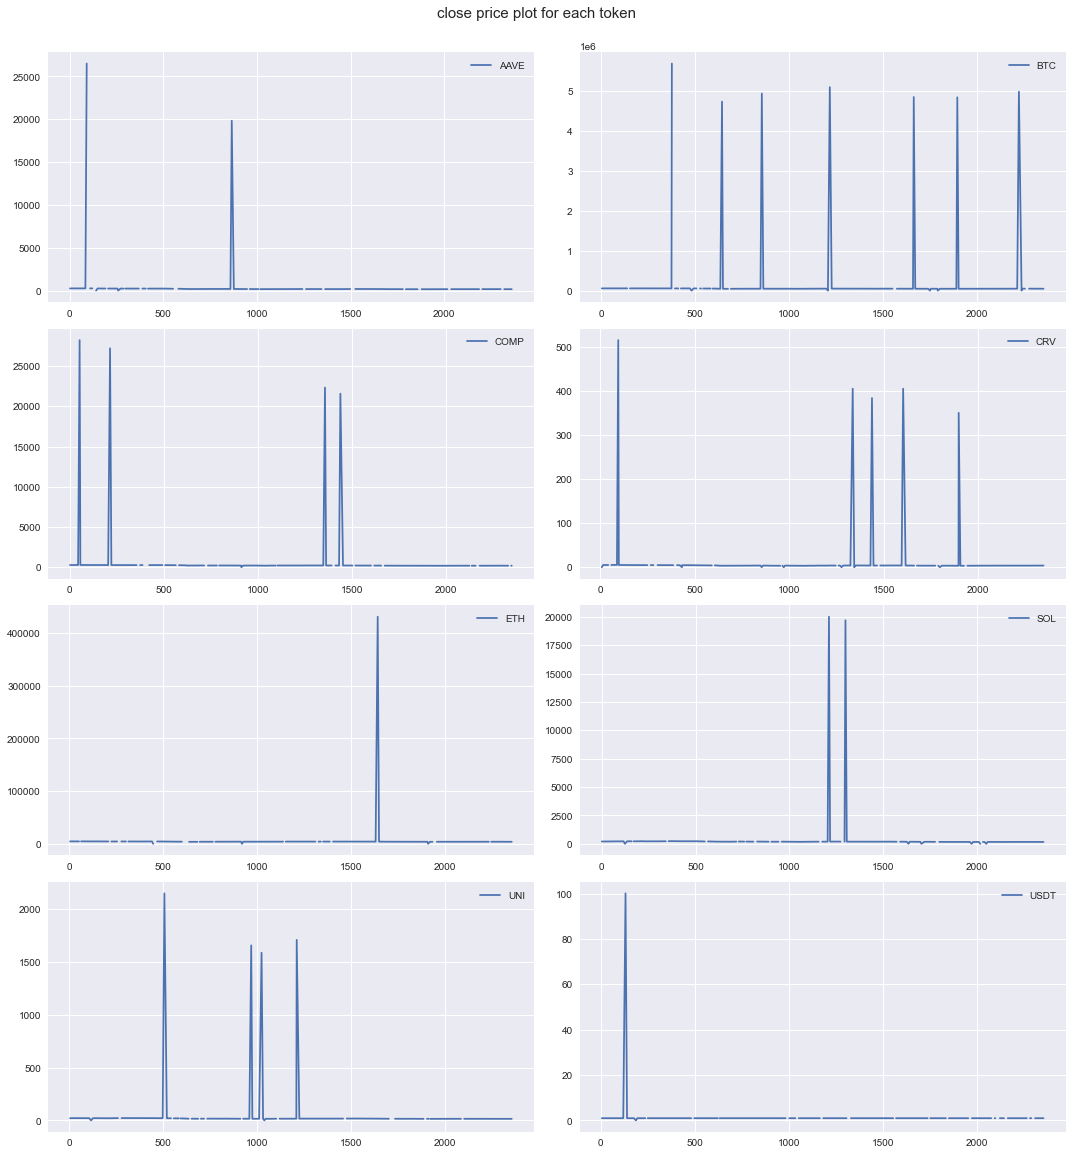

In [16]:
feature_plot(data, feature='close')

The plots above shows that:
+ There are some strange values in `close` needed to be replaced.
+ Obviously, there exists some missing data in `high`, `low` and `Close`(Further analysis in later part).

Let's take a look on the `close` columns first:

In [17]:
# take BTC as an example
btc = data[data['token']=='BTC'].reset_index(drop=True)
btc['close'].describe().to_frame()

,close
count,2.860000e+02
mean,1.717696e+05
std,7.705806e+05
min,4.768632e+02
25%,4.865738e+04
50%,4.953276e+04
75%,5.347901e+04
max,5.688883e+06


For _BTC_, **both of the max and min value** of `close` are abnormal.

Next we take a further look at the close price before and after the abnormal ones.

In [18]:
btc['prev_close'] = btc['close'].shift()
btc['next_close'] = btc['close'].shift(-1)
abnormal_close = btc.loc[(btc['close'] >= btc['open'] * 2) | (btc['close'] <= btc['open'] / 2), 
                         ['prev_close', 'close', 'next_close']]
abnormal_close

,prev_close,close,next_close
47,56905.81,5.688883e+06,NaN
60,56891.69,5.703374e+02,5.684069e+04
80,47711.33,4.734782e+06,4.759701e+04
107,49112.93,4.936795e+06,4.937094e+04
151,50943.63,5.122500e+02,5.097338e+06
152,512.25,5.097338e+06,5.127546e+04
208,48600.00,4.850319e+06,4.854675e+04
218,48047.25,4.843679e+02,4.855218e+04
224,47875.77,4.768632e+02,4.811026e+04
237,48121.77,4.842749e+06,4.793658e+04


By comparing the `prev_close` and `next_close` with the outliers, we can **guess with some confidence** that the abnormal value of `close` is **either 100 or 1/100 times of the 'true' value**. 

For other tokens, we detected them with the similar methods above and believe that the conclusion is adaptable for all tokens.

In [19]:
# times the abnormal value by 100 or 1/100 depends on whether it is too small or too large
data.loc[data['close'] >= data['open'] * 2, 'close'] = data.loc[data['close'] >= data['open'] * 2, 'close'] / 100
data.loc[data['close'] <= data['open'] / 2, 'close'] = data.loc[data['close'] <= data['open'] / 2, 'close'] * 100

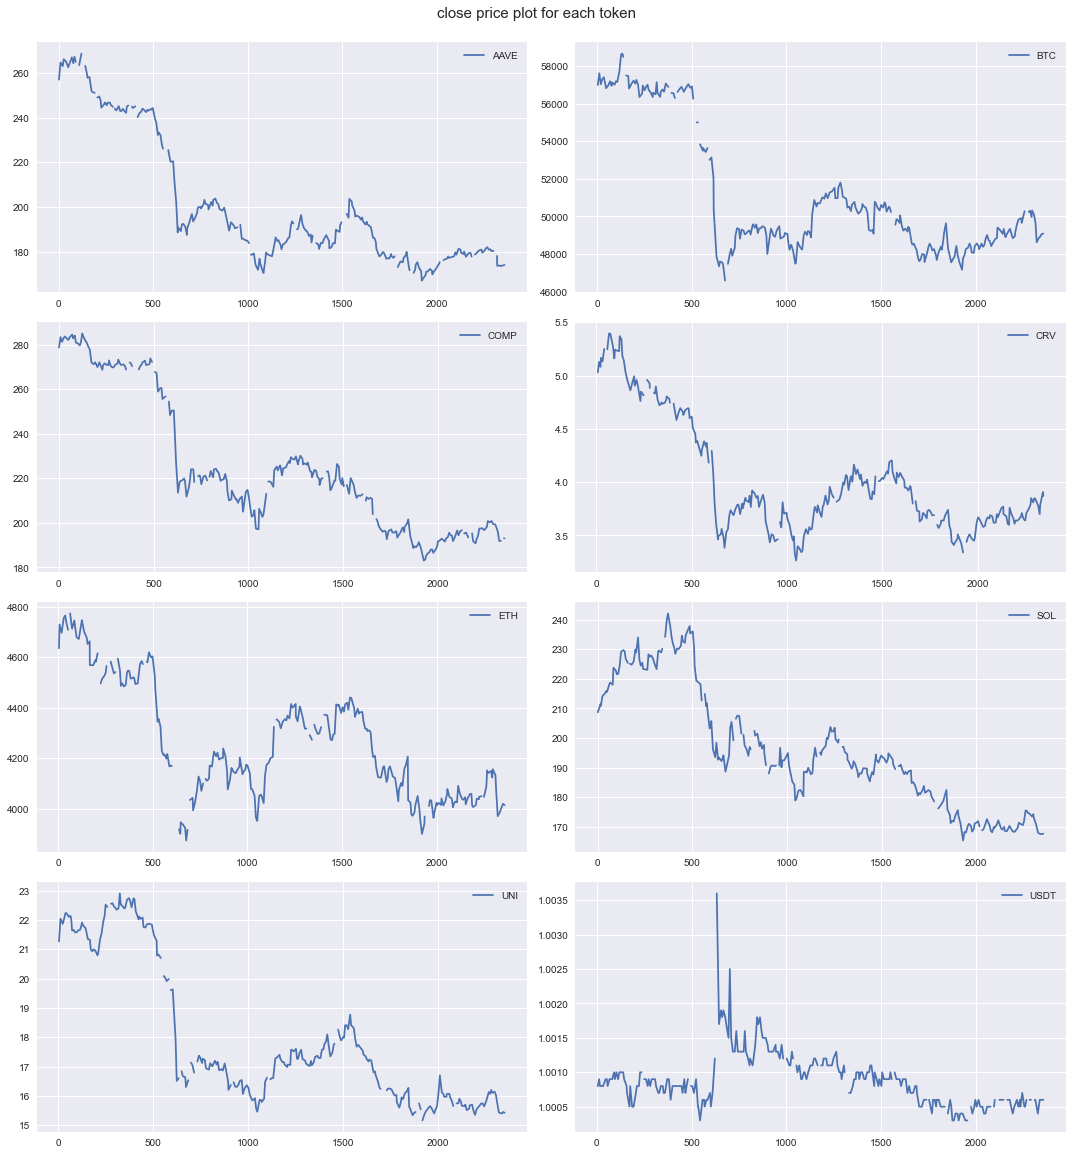

In [20]:
feature_plot(data, feature='close')

The `close` time series data looks better **without any obvious outliers**. Now we can focus on the missing values.

**4. fill in missing data**

In [21]:
data.isna().sum()

ts              0
open            0
high          450
low           256
close         116
volume          0
volumeUSD    2360
token           0
chain           0
dtype: int64

There are 4 columns having missing data and we have to fill in `high`, `low` and `close` first.

Since there is no missing data `open`, we can use the following fill-in strategies below:
+ `high`: For each nan value, calculate the mean of the difference between `high` and `open` in previous timestamps and add it to `open` in current timestamp.
+ `low`: For each nan value, calculate the mean of difference between `low` and `open` in previous timestamps and add it to `open` in current timestamp.
+ `close`: fill nan value by the mean of `high` and `low` in current timestamp.

Note that we have to fill the missing data for each token, **seperately**.

In [22]:
def tokenwise_fillna(token_data):
    # fill in high price
    fill_high = ((token_data['high'] - token_data['open']).cumsum() / np.arange(1, token_data.shape[0] + 1)).fillna(method='ffill').shift() + token_data['open']  # cummulated mean of previous (high - open) + current open price
    fill_high = np.nanmax([fill_high, token_data['open'], token_data['close']], axis=0)   # make sure fill-in high price is no less than open and close price
    token_data.loc[token_data['high'].isna(), 'high'] = fill_high[token_data['high'].isna()]
    
    # fill in low price
    fill_low = ((token_data['low'] - token_data['open']).cumsum() / np.arange(1, token_data.shape[0] + 1)).fillna(method='ffill').shift() + token_data['open'] # cummulated mean of previous (low - open) + current open price
    fill_low = np.nanmin([fill_low, token_data['open'], token_data['close']], axis=0)   # make sure fill-in low price is no larger than open and close price
    token_data.loc[token_data['low'].isna(), 'low'] = fill_low[token_data['low'].isna()]
    
    # keep the same digits as open price for each token (some tokens have 2 digits while others may have 3 or 4)
    keep_digits = len(str(token_data['open'].iloc[0]).split('.')[1])
    token_data['high'] = round(token_data['high'], keep_digits) 
    token_data['low'] = round(token_data['low'], keep_digits) 
    
    # fill in close price
    token_data.loc[token_data['close'].isna(), 'close'] = 0.5 * (token_data.loc[token_data['close'].isna(), 'high'] + 
                                                                 token_data.loc[token_data['close'].isna(), 'low'])
    return token_data

In [23]:
clean_data = data.groupby('token').apply(tokenwise_fillna)

Now the clean data have no missing values except for `volumeUSD`

In [24]:
clean_data.isna().sum()

ts              0
open            0
high            0
low             0
close           0
volume          0
volumeUSD    2360
token           0
chain           0
dtype: int64

Plot the `high`, `low` and `close` below

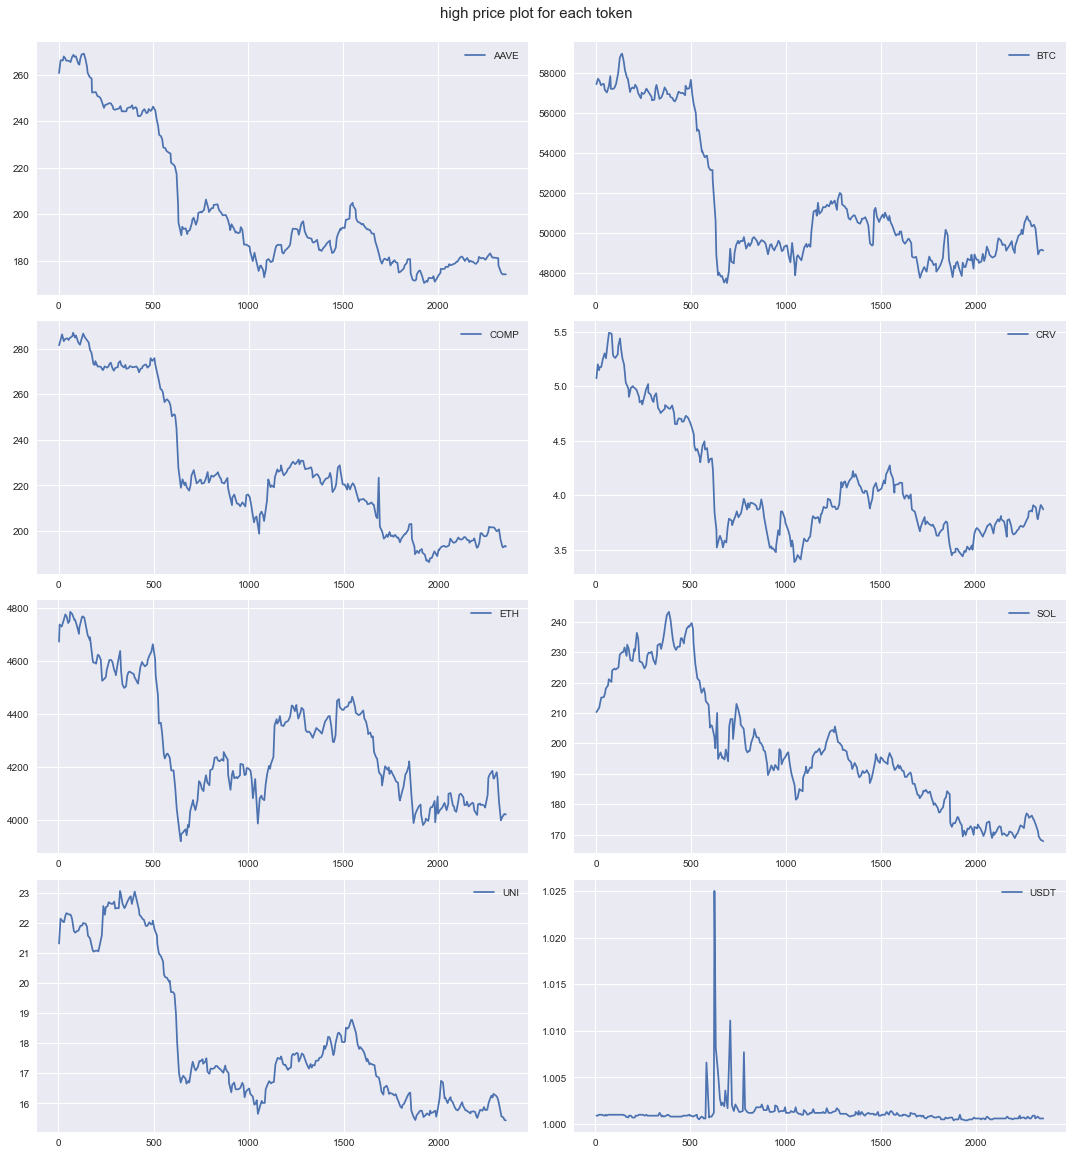

In [25]:
feature_plot(clean_data, 'high')

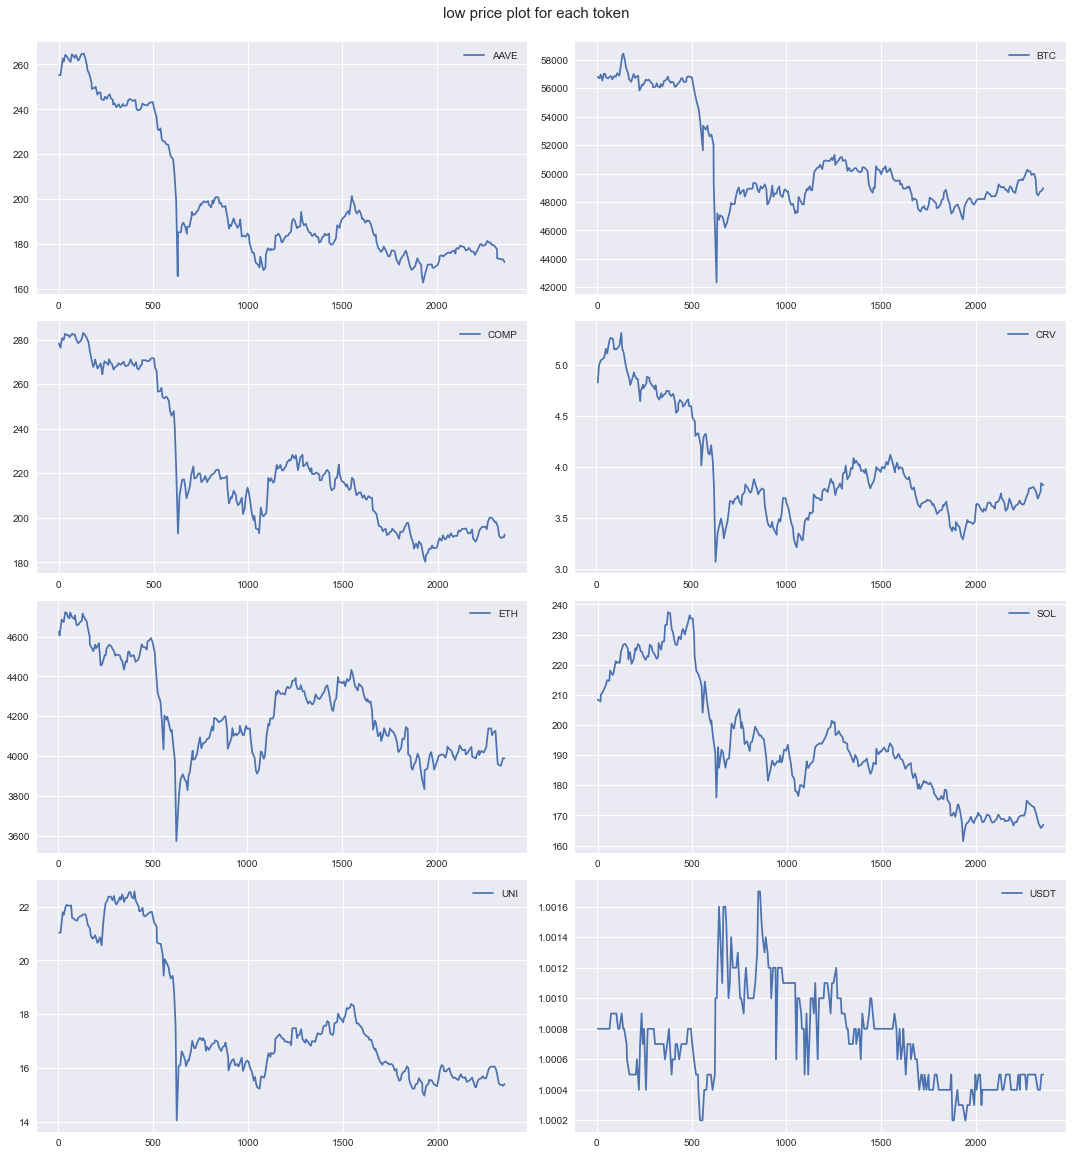

In [26]:
feature_plot(clean_data, 'low')

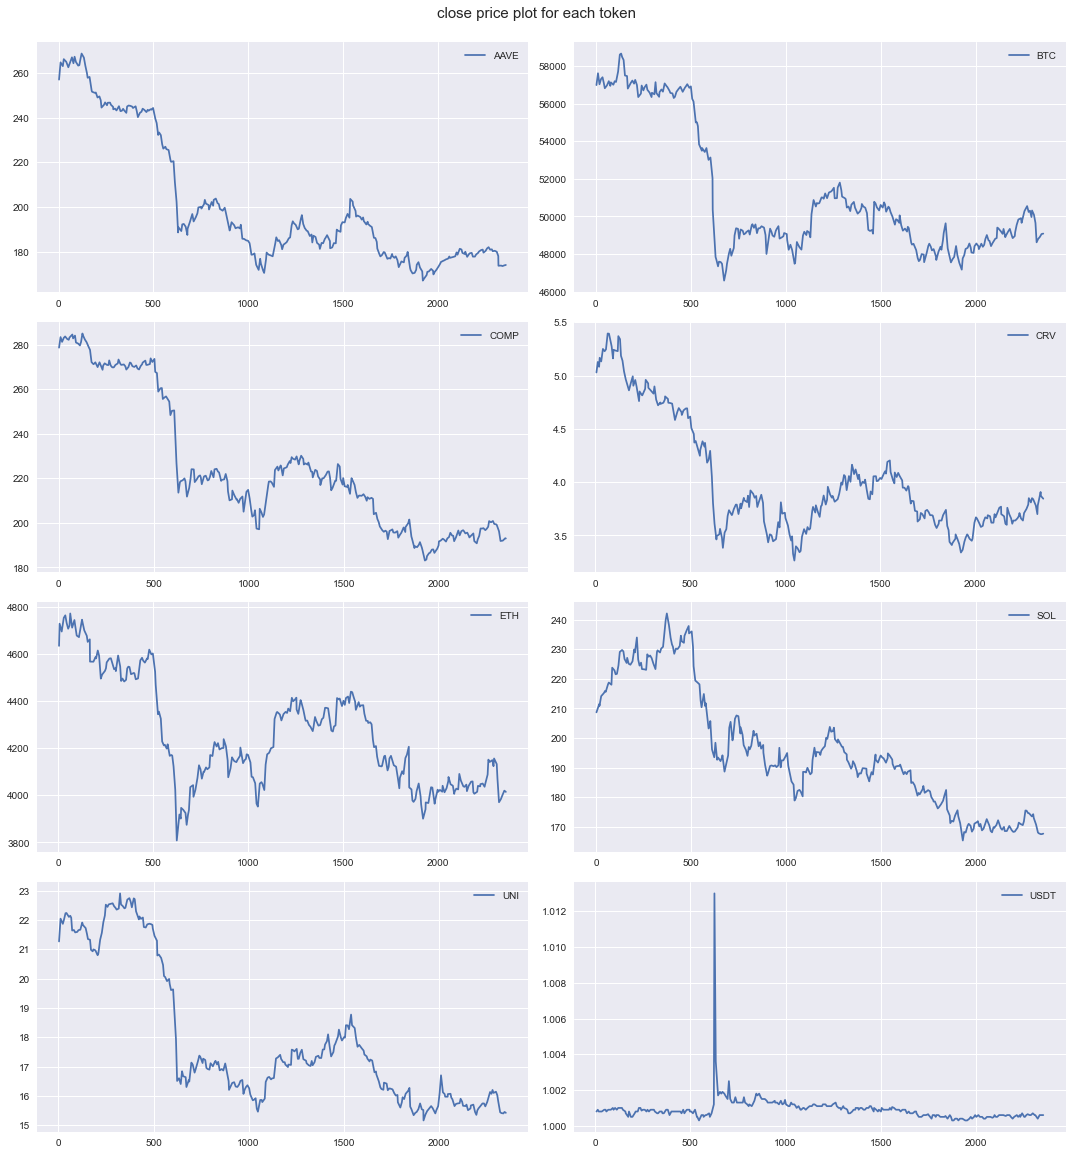

In [27]:
feature_plot(clean_data, 'close')

#### 3. calculate volumeUSD by chain

In [28]:
clean_data['volumeUSD'] = clean_data['volume'] * clean_data['close']

In [29]:
volumeUSD_by_chain = clean_data.groupby('chain')['volumeUSD'].sum().sort_values(ascending=False).to_frame()
volumeUSD_by_chain

,volumeUSD
chain,
ETH,1.364856e+10
BTC,1.095976e+10
SOL,4.076330e+09
USDT,1.008252e+09


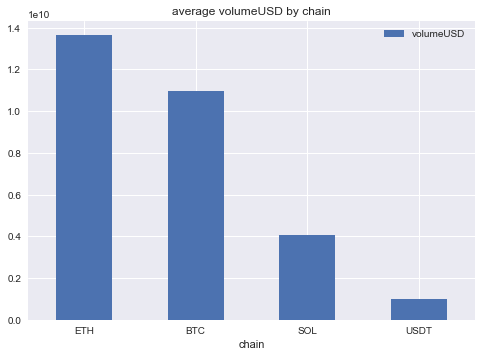

In [30]:
fig = volumeUSD_by_chain.plot(kind='bar', rot=0, title='average volumeUSD by chain')